In [1]:
import requests
import os

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import shapefile
import numpy as np
from glob import glob
import xarray as xr

from datetime import datetime
import metpy
from metpy.units import units
from ptype.plotting import get_tle_files, plot_ptype, plot_hrrr_ptype

In [2]:
reqheaders = {
    'content-type':'application/json',
    'Authorization': f'Token {os.environ["MPING_KEY"]}'
}

colors = {
    'Rain': 'limegreen', # Rain
    'Snow and/or Graupel': 'aqua',  # Snow
    'Freezing Rain': 'red',  # Freezing rain
    'Ice Pellets/Sleet': 'fuchsia'  # sleet
}

def get_json(reqheaders, obtime_gte, obtime_lte, in_bbox='-110, 36, -90, 48'): 
    reqparams = {
        'obtime_gte': obtime_gte,
        'obtime_lte': obtime_lte,
        'category': 'Rain/Snow',
        #'description_contains': 'Freezing',
        #'description_contains': 'Rain Freezing Sleet Ice Pellets Snow',
        'in_bbox': in_bbox
    }
    url = 'http://mping.ou.edu/mping/api/v2/reports'
    response = requests.get(url, params=reqparams, headers=reqheaders)

    if response.status_code != 200:
        print('Request Failed with status code %i', response.status_code)
        print("Response Reason:", response.reason)
        print("Response Content:", response.content)
        return None
    else:
        print('Request Successful')
        data = response.json()
        # Pretty print the data
        #print(json.dumps(data,indent=4))
        return data

In [3]:
def load_ensemble(files):
    ptypes = ['rain', 'snow', 'icep', 'frzr']
    ds = xr.open_mfdataset(files, parallel=True)
    #variables = ['ML_rain', 'ML_snow', 'ML_frzr', 'ML_icep', 'ML_cicep', 'ML_cfrzr', 'ML_crain', 'ML_csnow', 'csnow', 'crain', 'cicep', 'cfrzr', 't_h']
    
    #ds = ds[variables]
    vars = []
    
    precip_sum = ds[['crain', 'csnow', 'cicep', 'cfrzr']].to_array().sum(dim='variable')
    for ptype in ptypes:
        ds[f'ML_{ptype}'] = xr.where(precip_sum >= 1, x=ds[f'ML_{ptype}'], y=0) 
        vars.append(f'ML_{ptype}')

    ptype_hier = ['frzr', 'icep', 'snow', 'rain']
    concat = xr.concat([ds[f'ML_{ptype}'] for ptype in ptype_hier], dim='ptype')
    concat_tle = concat.mean("time")
    max_idx = concat_tle.argmax(dim='ptype')

    concat_hrrr = xr.concat([ds[f'c{ptype}'] for ptype in ptype_hier], dim='ptype')
    concat_hrrr_tle = concat_hrrr.mean("time")
    max_idx_tle = concat_hrrr_tle.argmax(dim='ptype')

    for i, ptype in enumerate(ptype_hier):
        ds[f'ML_c{ptype}'] = xr.where(max_idx == i, 1, np.nan)  # set categorical values
        ds[ptype] = ds[f'ML_c{ptype}'] * ds[f'ML_{ptype}']  # set categorical scaled by probability
        ds[f'c{ptype}'] = xr.where((max_idx_tle == i) & (concat_hrrr_tle[i] != 0), concat_hrrr_tle[i], np.nan)
        vars.append(f'ML_c{ptype}')
        vars.append(f'c{ptype}')
        vars.append(ptype)

    #ds = ds[vars].mean("time").apply(lambda x: x.where(x != 0, np.nan))  # average and set 0 to nan in one line
    #ds = ds.mean("time")
    mask = precip_sum.mean("time") <= 0
    
    ds_changed = ds[vars].mean("time").where(~mask) # only mean the selected variables
    ds = ds.update(ds_changed)
    return ds

In [10]:
def plot_mping(ax, results, colors, extent=[-108, -89, 37, 49]):
    for res in results:
        if res['description'] in colors:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color=colors[res['description']], label=res['description'])
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in colors.items()]
    ax.legend(handles=handles, loc='upper left')
    #ax.legend(loc='upper left')
    #shapefile_path = natural_earth(resolution='50m', category='cultural', name='populated_places')
    #reader = shapefile.Reader(shapefile_path)
    #for record in reader.iterShapeRecords():
    #    city = record.record['NAME']
    #    lon, lat = record.shape.points[0]
    #    if extent[0] <= lon <= extent[1] and extent[2] <= lat <= extent[3]:  # Filter cities within the map extent
    #        ax.plot(lon, lat, 'o', color='black', markersize=5, transform=ccrs.PlateCarree())
    #        ax.text(lon, lat, city, fontsize=8, transform=ccrs.PlateCarree(), ha='right')
    
    return ax

In [5]:
# Build kdTree
from pyproj import Proj, transform
from scipy.spatial import KDTree

class myKDTree():
    def __init__(self, longitudes, latitudes, proj):
        """
        Initialize the KDTreeHandler with latitude and longitude arrays.
        """
        self.latitudes = latitudes
        self.longitudes = longitudes
        self.proj = proj
        self.tree = None
        self.tree = self.build_tree()

    def build_tree(self):
        lcc_x, lcc_y = self.proj(self.longitudes, self.latitudes)
        lcc_points = np.vstack([lcc_x.ravel(), lcc_y.ravel()]).T
        tree = KDTree(lcc_points)
        return tree

    def query_tree(self, coord):
        # coord is (longitude, latitude)
        target_x, target_y = self.proj(coord[0], coord[1])
        distance, index = self.tree.query([target_x, target_y])
        y, x = divmod(index, latitudes.shape[1])
        return y, x

    def query(self, coords):
        '''
        Arguments:
            coords: list of coords in the form (longitude, latitude)
        '''
        coords = np.array(coords)
        target_x, target_y = self.proj(coords[:, 0], coords[:, 1])
        target_points = np.vstack([target_x, target_y]).T
        distances, indices = self.tree.query(target_points)
        y, x = np.divmod(indices, self.latitudes.shape[1])
        return y, x

In [6]:
def qc_mping(ds, json_data, snow_thresh=3, rain_thresh=-1, other_thresh=0, temp_crossings=(1, -2)):
    now = datetime.now()
    proj = Proj(proj='lcc', a=6371229, b=6371229, lon_0=262.5, lat_0=38.5, lat_1=38.5, lat_2=38.5)
    tree = myKDTree(ds.longitude, ds.latitude, proj)
    
    mping = []
    for res in json_data['results']:
        coord = res['geom']['coordinates']

        # find the closest grid points to the lat, lon coordinate
        i, j = tree.query_tree(coord)

        ptype = res['description']
        # evaluate the grid point 
        
        # calculate surface wetbulb temp:
        T2m = ds['t2m'][:, i, j].metpy.convert_units('degC')  # Assuming the temperature is in Kelvin, convert to Celsius
        D2m = ds['d2m'][:, i, j].metpy.convert_units('degC')  # Assuming the dew point temperature is in Kelvin, convert to Celsius
        SP = ds['sp'][:, i, j].metpy.convert_units('hPa')  # Assuming the pressure is in Pa, convert to hPa

        # Ensure the data has units attached
        T2m = T2m.metpy.quantify()
        D2m = D2m.metpy.quantify()
        SP = SP.metpy.quantify()
                
        wbulb = metpy.calc.wet_bulb_temperature(SP, T2m, D2m).mean("time").values

        if ptype == 'Snow and/or Graupel':
            if np.any(wbulb < snow_thresh):
                mping.append(res)
        elif ptype == 'Rain':
            if np.any(wbulb > rain_thresh):
                mping.append(res)
        elif ptype == 'Freezing Rain' or ptype == 'Ice Pellets/Sleet':
            # check if temp crosses 0 celsius at least once.
            m = ds['t_h'][:, :, i, j].mean("time").values
            within_range = np.any(m > temp_crossings[0]) & np.any(m < temp_crossings[1])
            # at least one temp crossing and mping[filter] one temp crossing across all height levels
            if within_range and wbulb < other_thresh:
                mping.append(res)
    print(datetime.now() - now)
    return mping

In [7]:
def plot_prob_coords(tree, json_results, ptype, longn_ptype):
    coords = []
    for res in json_results:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            coords.append((coord[0] + 360, coord[1]))
    
    lat = ds.latitude.values
    lon = ds.longitude.values
    print(lat.shape)
    indices = []
    lcc = ccrs.PlateCarree()
    for lon_p, lat_p in coords:
        i, j = tree.query_tree((lon_p, lat_p))
        indices.append((i, j))
        print(f"Coordinate {lon_p}, {lat_p} is closest to grid point (lon, lat) = ({lon[i][j]}, {lat[i][j]}) at row {i}, col {j}")
    
    prob = ds[f'ML_{ptype}'].values
    prob_labels = [prob[i][j] for i, j in indices]
    print(prob_labels)
    lat_labels = [ds.latitude[i][j] for i, j in indices]
    lon_labels = [ds.longitude[i][j] for i, j in indices]
    
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_results:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])
    
    # Annotate each point with its label
    for i, txt in enumerate(prob_labels):
        ax.annotate(f'{txt:.3f}', (lon_labels[i], lat_labels[i]), xytext=(5,-5), textcoords='offset points', transform=ccrs.PlateCarree())
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

In [8]:
def temp_sounding(ds, idx, num_members=18):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'skewx', 'rotation': 30})
    ax.set_ylabel("Height above ground (m)", fontsize=10)
    ax.grid(which="both")
    major_ticks = np.arange(-100, 100, 5)
    ax.set_xticks(major_ticks)
    ax.grid(which="major", alpha=0.5)
    ax.axvline(x=0, ymin=0, ymax=1, c="0")
    ax.set_ylim(-100, 5100)
    ax.set_xlim(-10, 25)
    
    colors = cm.viridis(np.linspace(0, 1, num_members))
    cmap = mcolors.ListedColormap(colors)
    bounds = np.arange(1, num_members + 2) - 0.5
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    labels = []
    temp = ds['t_h'][:, :, idx[0], idx[1]]
    heights = ds.heightAboveGround
    times = ds.time.values
    for i in range(0, num_members):
        color = cmap(norm(i))
        time = times[i]
        dt_py = time.astype('M8[s]').astype(datetime)
        formatted = dt_py.strftime('%m-%d %H:00')
        
        ax.plot(temp[i], heights, color=color, alpha=0.6, linewidth=2)
        labels.append(formatted)
    
    ax.set_xlabel('Temperature (°C)')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', boundaries=bounds)
    cbar.set_label('Ensemble Member')
    cbar.set_ticks(np.arange(1, num_members+1))
    cbar.set_ticklabels(labels)
    plt.title(ds.valid_time.values.astype('datetime64[s]'))

## Case Study 1: 2024-03-24 1400

In [99]:
valid_time = f'2024-03-24 1400'
base_path = '/glade/campaign/cisl/aiml/ptype_historical/winter_2023_2024_extended/no_winds/hrrr'
#base_path = '/glade/work/sreiner/ptype_real_time/extended_region/hrrr'
#base_path = '/glade/derecho/scratch/cbecker/ptype_real_time/winter_2023_2024/hrrr'
n_members = 18

colors = {
    'Rain': 'limegreen', # Rain
    'Snow and/or Graupel': 'aqua',  # Snow
    'Freezing Rain': 'red',  # Freezing rain
    'Ice Pellets/Sleet': 'fuchsia'  # sleet
}

tle_files = get_tle_files(base_path, valid_time, n_members)

When making the query to the mPING API, specify year, month, day, and hour. The hour field grabs data from the hour following the requested hour.

In [100]:
json_data = get_json(reqheaders, '2024-03-24 14:00:00', '2024-03-24 14:59:59', in_bbox='-110, 36, -83, 49')
print(json_data['results'][:5])

Request Successful
[{'id': 3908778, 'obtime': '2024-03-24T14:00:35Z', 'category': 'Rain/Snow', 'description': 'Snow and/or Graupel', 'description_id': 8, 'geom': {'type': 'Point', 'coordinates': [-92.87374, 43.0522754]}}, {'id': 3908779, 'obtime': '2024-03-24T14:01:20Z', 'category': 'Rain/Snow', 'description': 'Snow and/or Graupel', 'description_id': 8, 'geom': {'type': 'Point', 'coordinates': [-88.103044, 44.409498]}}, {'id': 3908780, 'obtime': '2024-03-24T14:02:54Z', 'category': 'Rain/Snow', 'description': 'Snow and/or Graupel', 'description_id': 8, 'geom': {'type': 'Point', 'coordinates': [-93.7026074, 45.3404383]}}, {'id': 3908782, 'obtime': '2024-03-24T14:03:32Z', 'category': 'Rain/Snow', 'description': 'Rain', 'description_id': 3, 'geom': {'type': 'Point', 'coordinates': [-97.86930492734356, 38.08625623966459]}}, {'id': 3908783, 'obtime': '2024-03-24T14:04:22Z', 'category': 'Rain/Snow', 'description': 'Rain', 'description_id': 3, 'geom': {'type': 'Point', 'coordinates': [-97.9307

Plotting mPING data over ptype categorization

In [101]:
ds = load_ensemble(tle_files)

In [10]:
ds

<xarray.Dataset> Size: 9GB
Dimensions:            (time: 18, heightAboveGround: 21, y: 487, x: 732,
                        isobaricInhPa: 40)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 168B 0 250 500 ... 4750 5000
  * time               (time) datetime64[ns] 144B 2024-03-23T20:00:00 ... 202...
    step               (time) timedelta64[ns] 144B 18:00:00 ... 01:00:00
  * isobaricInhPa      (isobaricInhPa) float32 160B 1.013e+03 1e+03 ... 50.0
    latitude           (y, x) float32 1MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    longitude          (y, x) float32 1MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    valid_time         datetime64[ns] 8B 2024-03-24T14:00:00
    atmosphere         float32 4B 0.0
Dimensions without coordinates: y, x
Data variables: (12/42)
    t_h                (time, heightAboveGround, y, x) float32 539MB dask.array<chunksize=(1, 11, 244, 366), meta=np.ndarray>
    dpt_h              (time, heightAboveGround, y, x) float32 539MB dask.array<chunksize=(1, 11, 244, 366), meta=np.ndarray>
    isobaricInhPa_h    (time, heightAboveGround, y, x) float64 1GB dask.array<chunksize=(1, 11, 244, 366), meta=np.ndarray>
    t                  (time, isobaricInhPa, y, x) float32 1GB dask.array<chunksize=(1, 20, 244, 366), meta=np.ndarray>
    u                  (time, isobaricInhPa, y, x) float32 1GB dask.array<chunksize=(1, 20, 244, 366), meta=np.ndarray>
    v                  (time, isobaricInhPa, y, x) float32 1GB dask.array<chunksize=(1, 20, 244, 366), meta=np.ndarray>
    ...                 ...
    ML_frzr            (y, x) float32 1MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    ML_cfrzr           (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    frzr               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    icep               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    snow               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>
    rain               (y, x) float64 3MB dask.array<chunksize=(487, 732), meta=np.ndarray>

Evidental model ptype categorization

In [102]:
lcc_proj = Proj(proj='lcc', a=6371229, b=6371229, lon_0=262.5, lat_0=38.5, lat_1=38.5, lat_2=38.5)
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values

tree = myKDTree(longitudes, latitudes, lcc_proj)

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

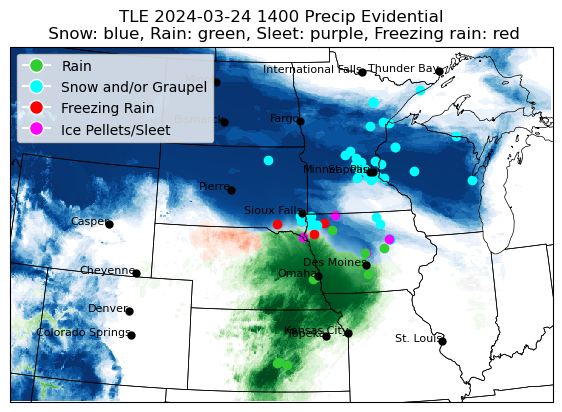

In [103]:
ax = plot_ptype(ds, cmap=['Greens', 'Blues', 'Reds','Grays'], ptypes=['rain', 'snow', 'frzr', 'icep'], extent = [-110, -85.5, 36, 49])
plot_mping(ax, json_data['results'], colors)
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

Get the qc'd mping data

In [104]:
qc_data = qc_mping(ds, json_data)

0:01:07.228358


Text(0.5, 1.0, 'QC TLE 2024-03-24 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

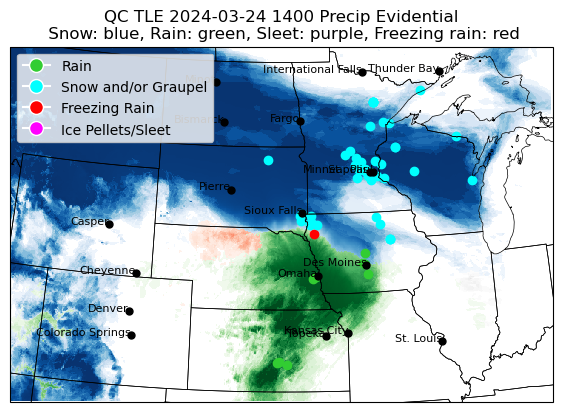

In [105]:
ax = plot_ptype(ds, cmap=['Greens', 'Blues', 'Reds','Grays'], ptypes=['rain', 'snow', 'frzr', 'icep'], extent = [-110, -85.5, 36, 49])
plot_mping(ax, qc_data, colors)
plt.title(f'QC TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

HRRR categorization

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

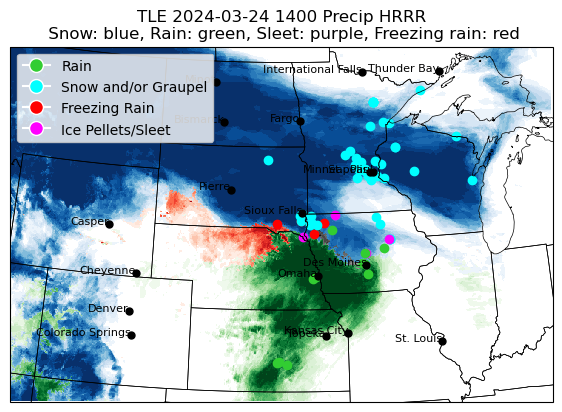

In [106]:
ax = plot_hrrr_ptype(ds, extent = [-110, -85.5, 36, 49])
plot_mping(ax, json_data['results'], colors)
plt.title(f'TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

Text(0.5, 1.0, 'QC TLE 2024-03-24 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

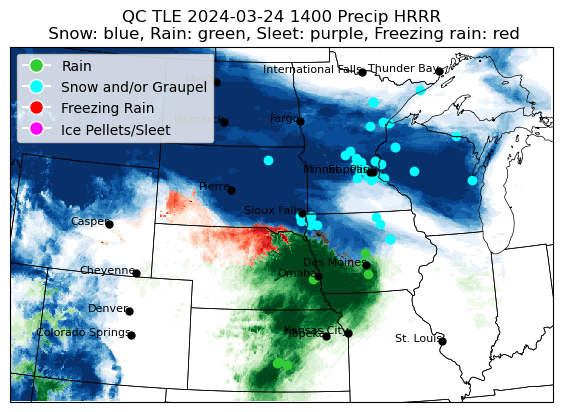

In [23]:
ax = plot_hrrr_ptype(ds, extent = [-110, -85.5, 36, 49])
plot_mping(ax, qc_data, colors)
plt.title(f'QC TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

This doesn't tell the full story, especially since we make the categorizations in the Evidential model by taking the maximum probability across the 4 ptypes. Then if two probabilities are relatively close, that won't be represented in this plot. Instead, plot the mPING data on top of its corresponding probability. 

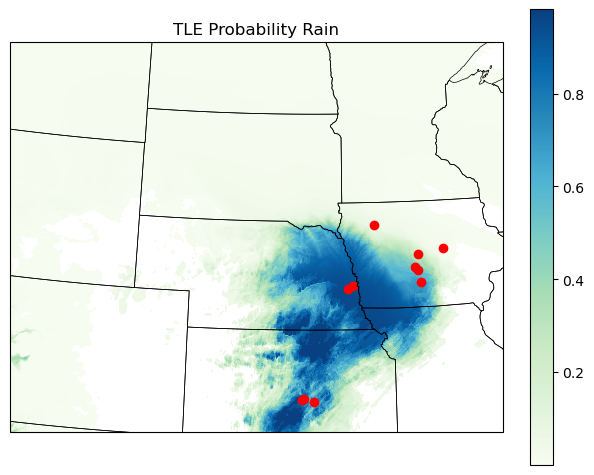

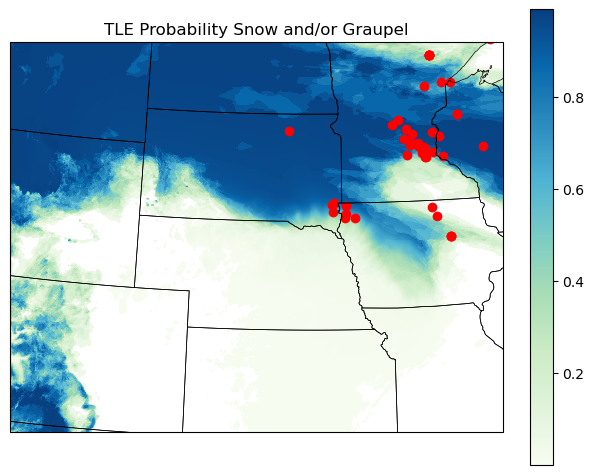

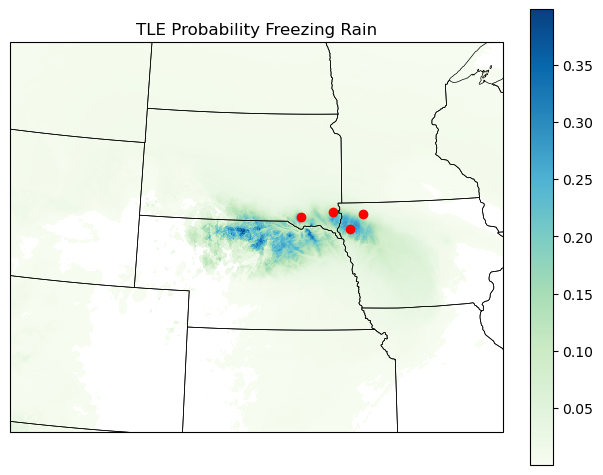

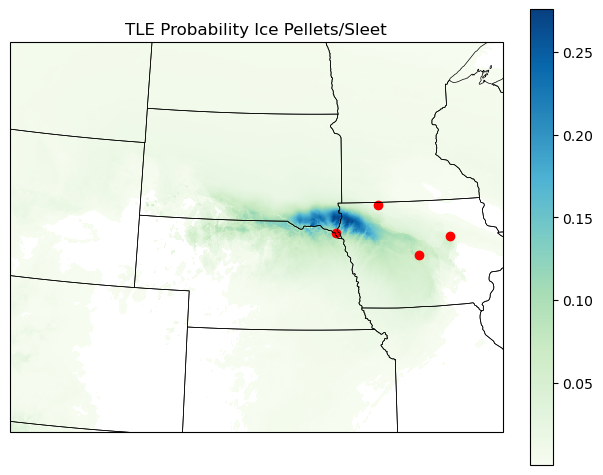

In [107]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

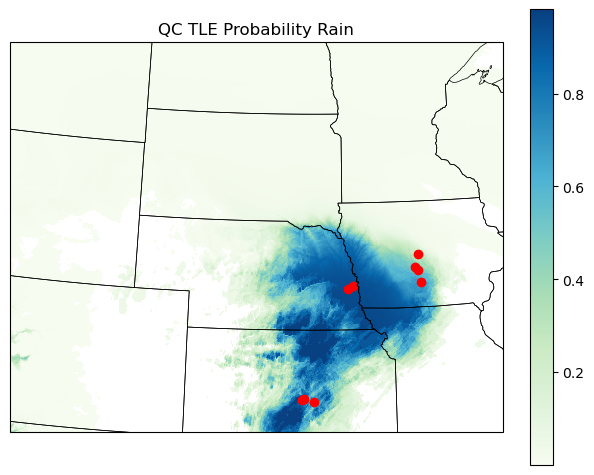

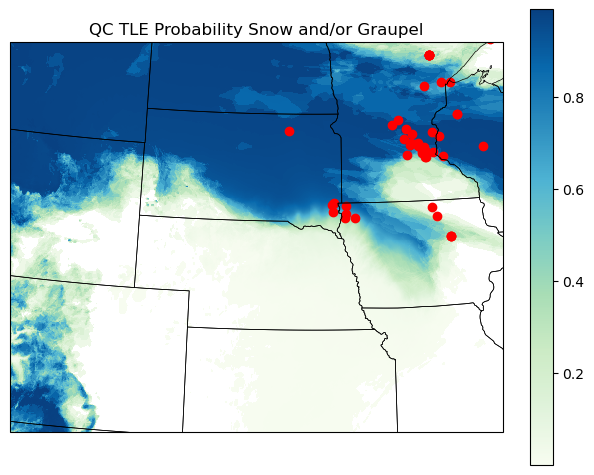

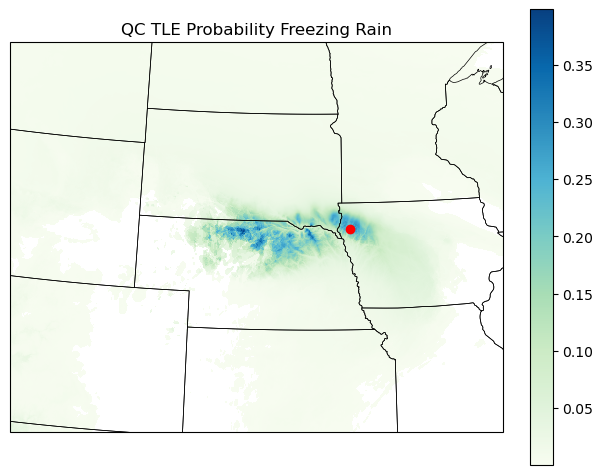

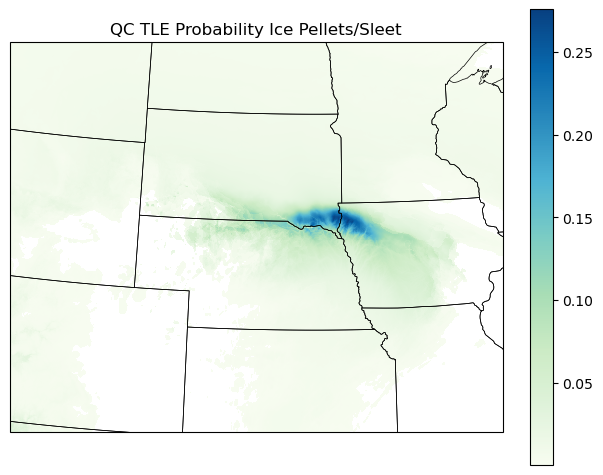

In [108]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in qc_data:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'QC TLE Probability {longn_ptype}')

(487, 732)
Coordinate 263.8493580277114, 42.78487937063238 is closest to grid point (lon, lat) = (263.8497619628906, 42.775535583496094) at row 226, col 411
[0.2227512]


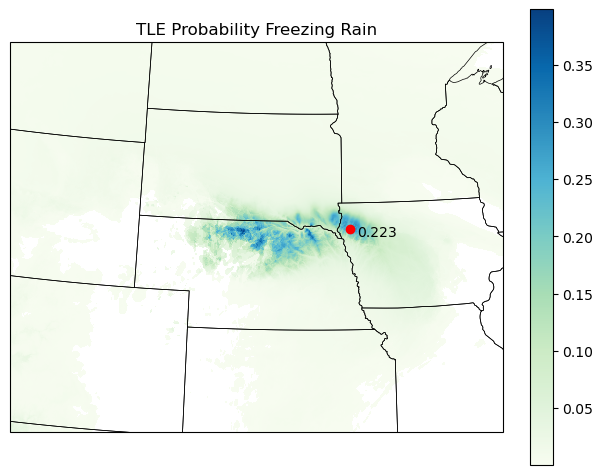

In [111]:
plot_prob_coords(tree, qc_data, 'frzr', 'Freezing Rain')

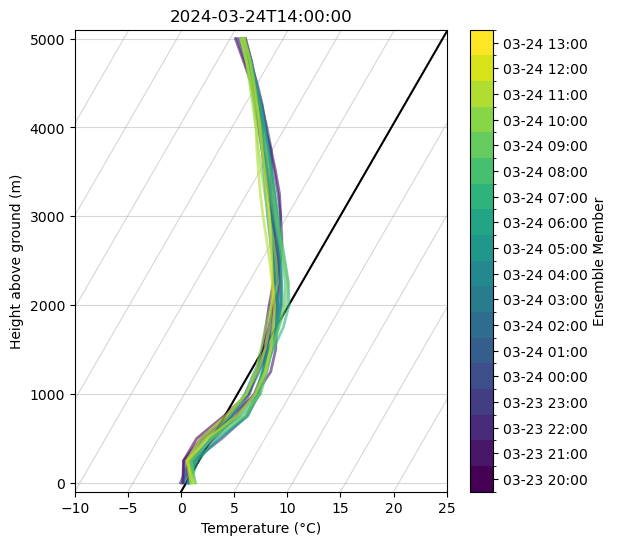

In [110]:
temp_sounding(ds, (226, 411) , 18)

(487, 732)
Coordinate 264.9072453, 43.4412225 is closest to grid point (lon, lat) = (264.8995361328125, 43.43231201171875) at row 251, col 439
Coordinate 263.3208671, 42.6821695 is closest to grid point (lon, lat) = (263.3353271484375, 42.67239761352539) at row 222, col 397
Coordinate 267.5674964152255, 42.50004392109662 is closest to grid point (lon, lat) = (267.5693054199219, 42.49155807495117) at row 219, col 513
Coordinate 266.38833691673403, 42.017186341055506 is closest to grid point (lon, lat) = (266.37322998046875, 42.02251052856445) at row 200, col 481
[0.015309651, 0.07526991, 0.026187472, 0.06277805]


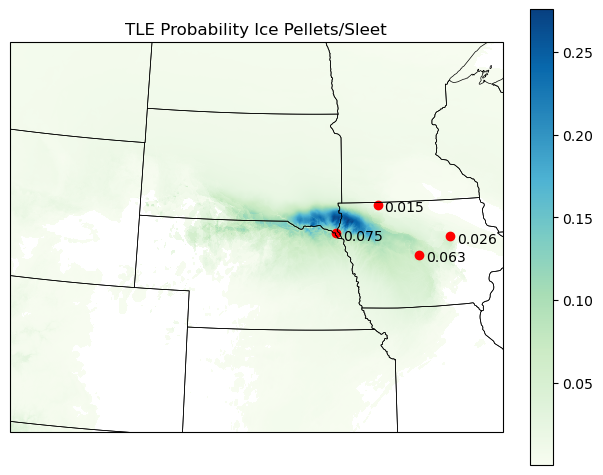

In [112]:
plot_prob_coords(tree, json_data['results'], 'icep', 'Ice Pellets/Sleet')

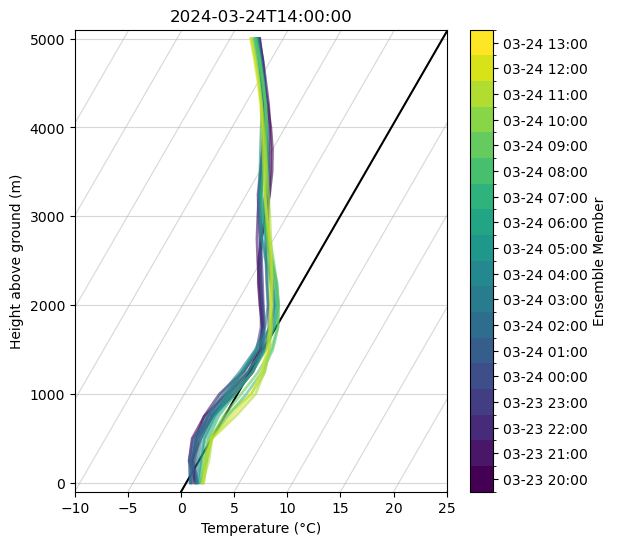

In [113]:
temp_sounding(ds, (200, 481), 18)

Here's some similar plots as above although since we don't have probabilities for HRRR per say, we can instead calculate the mean across all 18 ensemble members, which represents proportions. 

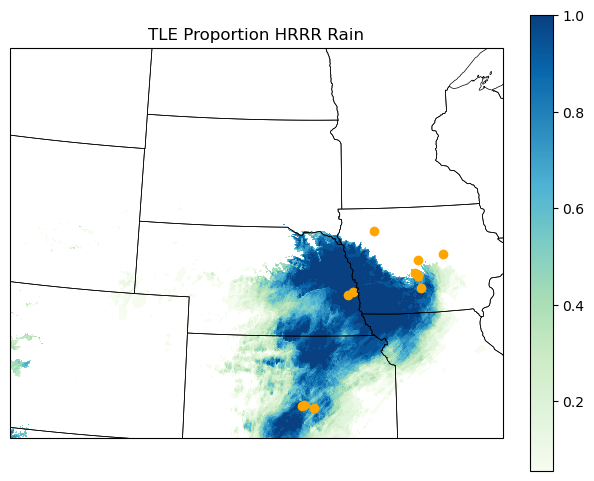

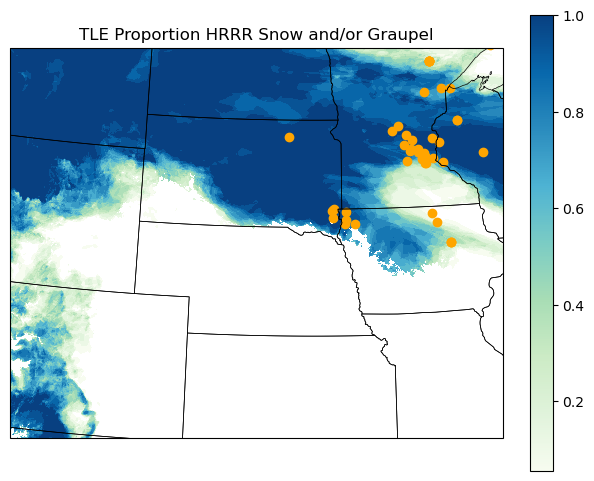

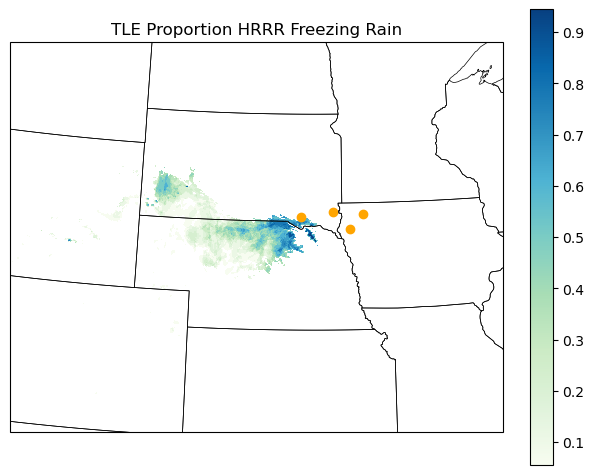

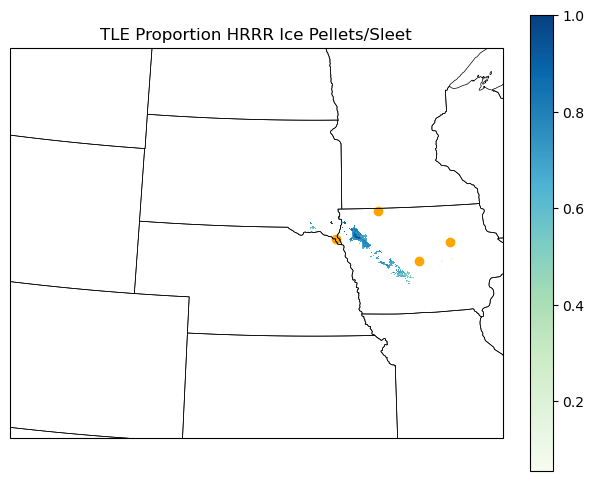

In [27]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'c{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Proportion HRRR {longn_ptype}')

Let's take a closer look at some of the locations which don't match high probabilities

In [28]:
icep_coords = []
for res in json_data['results']:
    if res['description'] == 'Ice Pellets/Sleet':
        coord = res['geom']['coordinates']
        icep_coords.append(coord)

icep_coords

[[-95.0927547, 43.4412225],
 [-96.6791329, 42.6821695],
 [-92.43250358477448, 42.50004392109662],
 [-93.61166308326594, 42.017186341055506]]

In [16]:
# find closet indices in lat, lon grids to the coordinates

In [29]:
lat = ds.latitude.values
lon = ds.longitude.values
print(lat.shape)
indices = []
lcc = ccrs.PlateCarree()
for coord in icep_coords:
    i, j = tree.query_tree(coord)
    indices.append((i, j))
    print(f"Coordinate {coord[0]}, {coord[1]} is closest to grid point (lon, lat) = ({lon[i][j]}, {lat[i][j]}) at row {i}, col {j}")

(487, 732)
Coordinate -95.0927547, 43.4412225 is closest to grid point (lon, lat) = (264.8995361328125, 43.43231201171875) at row 251, col 439
Coordinate -96.6791329, 42.6821695 is closest to grid point (lon, lat) = (263.3353271484375, 42.67239761352539) at row 222, col 397
Coordinate -92.43250358477448, 42.50004392109662 is closest to grid point (lon, lat) = (267.5693054199219, 42.49155807495117) at row 219, col 513
Coordinate -93.61166308326594, 42.017186341055506 is closest to grid point (lon, lat) = (266.37322998046875, 42.02251052856445) at row 200, col 481


In [71]:
ix, jx = tree.query(icep_coords)
print(ix, jx)
for i, j in zip(ix, jx):
    print(f"Coordinate is closest to grid point (lon, lat) = ({lon[i][j]}, {lat[i][j]}) at row {i}, col {j}")

[259 230 227 208] [379 337 453 421]
Coordinate is closest to grid point (lon, lat) = (264.8995361328125, 43.43231201171875) at row 259, col 379
Coordinate is closest to grid point (lon, lat) = (263.3353271484375, 42.67239761352539) at row 230, col 337
Coordinate is closest to grid point (lon, lat) = (267.5693054199219, 42.49155807495117) at row 227, col 453
Coordinate is closest to grid point (lon, lat) = (266.37322998046875, 42.02251052856445) at row 208, col 421


Text(0.5, 1.0, 'TLE Probability Ice Pellets/Sleet')

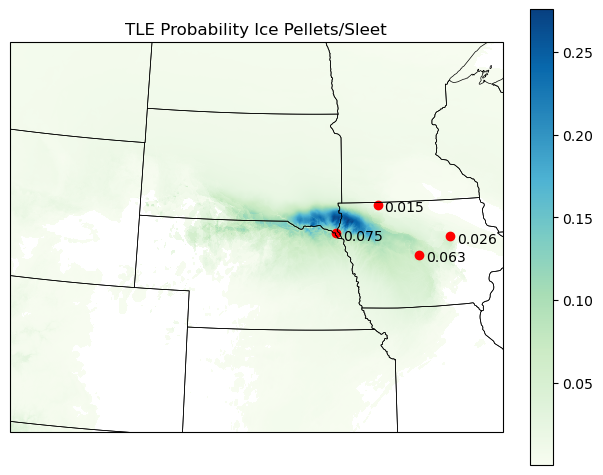

In [30]:
ptype = 'icep'
longn_ptype = 'Ice Pellets/Sleet'

prob = ds[f'ML_{ptype}'].values
prob_labels = [prob[i][j] for i, j in indices]
lat_labels = [ds.latitude[i][j] for i, j in indices]
lon_labels = [ds.longitude[i][j] for i, j in indices]

projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
ax.add_feature(cfeature.STATES, linewidth=0.5)

for res in json_data['results']:
    if res['description'] == longn_ptype:
        coord = res['geom']['coordinates']
        ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])

# Annotate each point with its label
for i, txt in enumerate(prob_labels):
    ax.annotate(f'{txt:.3f}', (lon_labels[i], lat_labels[i]), xytext=(5,-5), textcoords='offset points', transform=ccrs.PlateCarree())

plt.colorbar(pcm, ax=ax, fraction=0.042)
plt.title(f'TLE Probability {longn_ptype}')

Now let's look at the hour BEFORE the valid time to see if there's any differences.

In [21]:
json_data = get_json(reqheaders, '2024-03-24 13:00:00', '2024-03-24 13:59:59')
json_data['results'][:2]

Request Successful


[{'id': 3908716,
  'obtime': '2024-03-24T13:01:57Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point',
   'coordinates': [-92.70174270504405, 44.927186910104865]}},
 {'id': 3908717,
  'obtime': '2024-03-24T13:03:32Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point', 'coordinates': [-90.8989557, 46.6733116]}}]

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

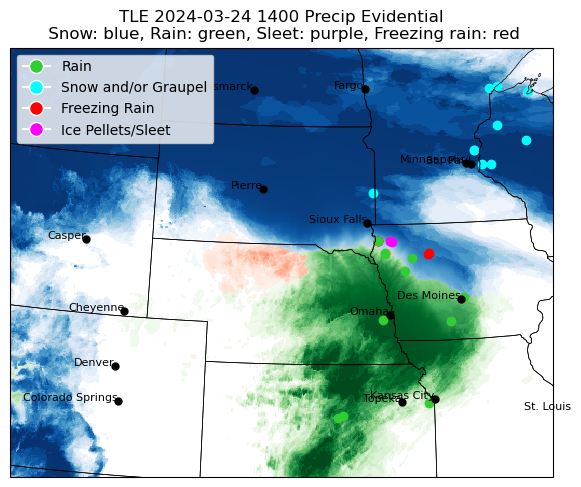

In [20]:
ax = plot_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

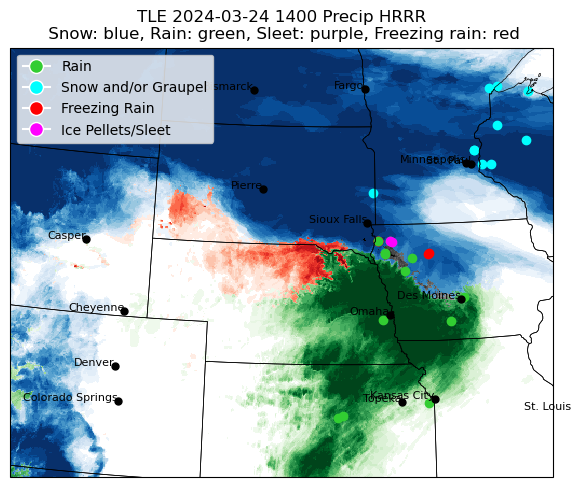

In [21]:
ax = plot_hrrr_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

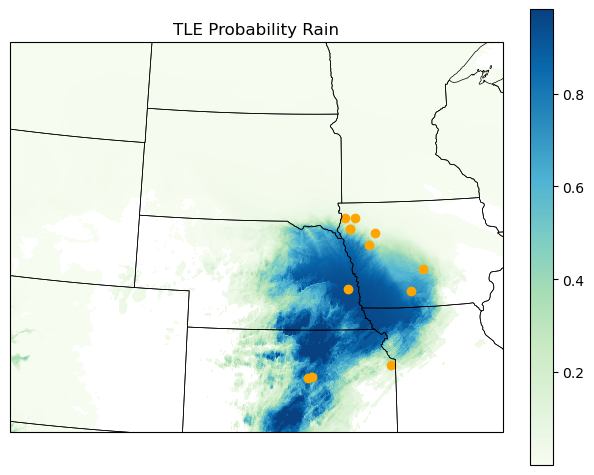

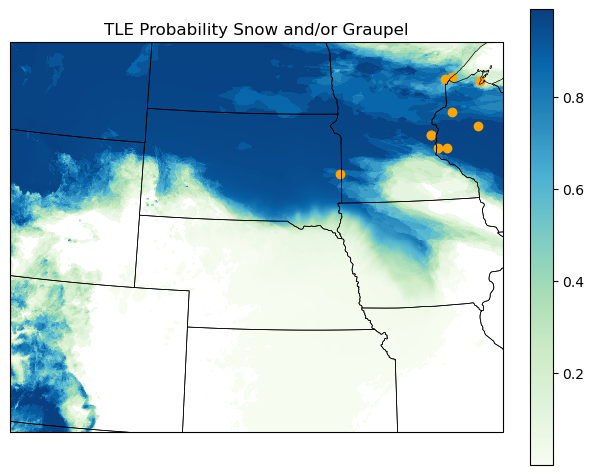

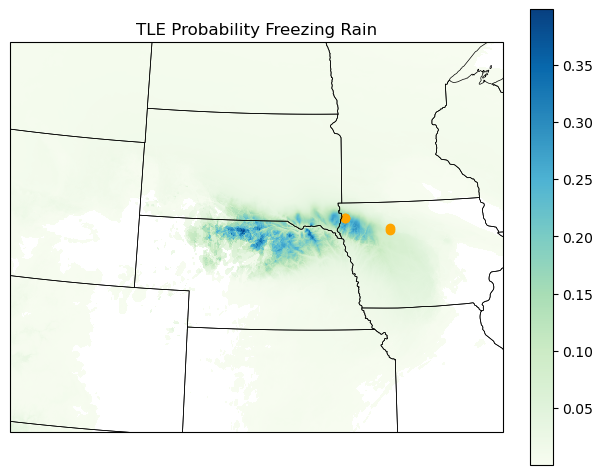

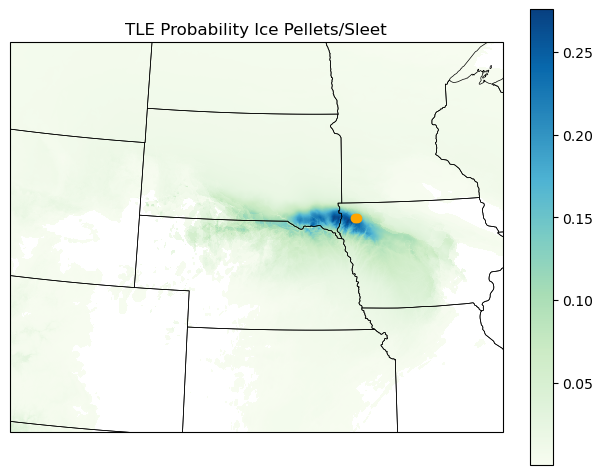

In [22]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

(439, 528)
Coordinate -95.0927547, 43.4412225 is closest to grid point (lon, lat) = (264.8995361328125, 43.43231201171875) at row 259, col 379
Coordinate -96.6791329, 42.6821695 is closest to grid point (lon, lat) = (263.3353271484375, 42.67239761352539) at row 230, col 337
Coordinate -92.43250358477448, 42.50004392109662 is closest to grid point (lon, lat) = (267.5693054199219, 42.49155807495117) at row 227, col 453
Coordinate -93.61166308326594, 42.017186341055506 is closest to grid point (lon, lat) = (266.37322998046875, 42.02251052856445) at row 208, col 421


Text(0.5, 1.0, 'TLE Probability Ice Pellets/Sleet')

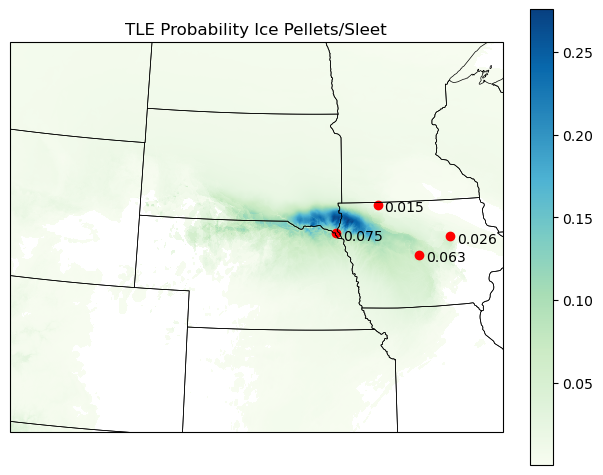

In [42]:
icep_coords = []
for res in json_data['results']:
    if res['description'] == 'Ice Pellets/Sleet':
        coord = res['geom']['coordinates']
        icep_coords.append((coord[0], coord[1]))

lat = ds.latitude.values
lon = ds.longitude.values
print(lat.shape)
indices = []
for coord in icep_coords:
    i, j = tree.query_tree(coord)
    indices.append((i, j))
    print(f"Coordinate {coord[0]}, {coord[1]} is closest to grid point (lon, lat) = ({lon[i][j]}, {lat[i][j]}) at row {i}, col {j}")

ptype = 'icep'
longn_ptype = 'Ice Pellets/Sleet'

prob = ds[f'ML_{ptype}'].values
prob_labels = [prob[i][j] for i, j in indices]
lat_labels = [ds.latitude[i][j] for i, j in indices]
lon_labels = [ds.longitude[i][j] for i, j in indices]

projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
ax.add_feature(cfeature.STATES, linewidth=0.5)

for res in json_data['results']:
    if res['description'] == longn_ptype:
        coord = res['geom']['coordinates']
        ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])

# Annotate each point with its label
for i, txt in enumerate(prob_labels):
    ax.annotate(f'{txt:.3f}', (lon_labels[i], lat_labels[i]), xytext=(5,-5), textcoords='offset points', transform=ccrs.PlateCarree())

plt.colorbar(pcm, ax=ax, fraction=0.042)
plt.title(f'TLE Probability {longn_ptype}')

## Case Study 2: 2023-12-25 1400

In [11]:
base_path = '/glade/work/sreiner/ptype_real_time/extended_region/hrrr'
valid_time = '2023-12-25 1400'
n_members = 18
tle_files = get_tle_files(base_path, valid_time, n_members)
json_data = get_json(reqheaders, '2023-12-25 14:00:00', '2023-12-25 14:59:59', in_bbox='-110, 36, -83, 49')
ds = load_ensemble(tle_files)

Request Successful


In [12]:
lcc_proj = Proj(proj='lcc', a=6371229, b=6371229, lon_0=262.5, lat_0=38.5, lat_1=38.5, lat_2=38.5)
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values

tree = myKDTree(longitudes, latitudes, lcc_proj)

In [13]:
qc_data = qc_mping(ds, json_data)

0:00:42.921089


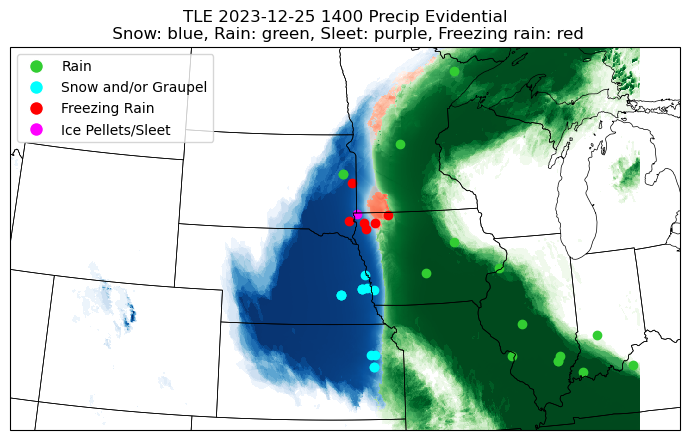

In [14]:
ax = plot_ptype(ds, extent=[-110, -84, 36, 48])
plot_mping(ax, json_data['results'], colors)
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')
plt.tight_layout()
plt.savefig("ptype_mping_2023-12-25_1400.png", dpi=300)

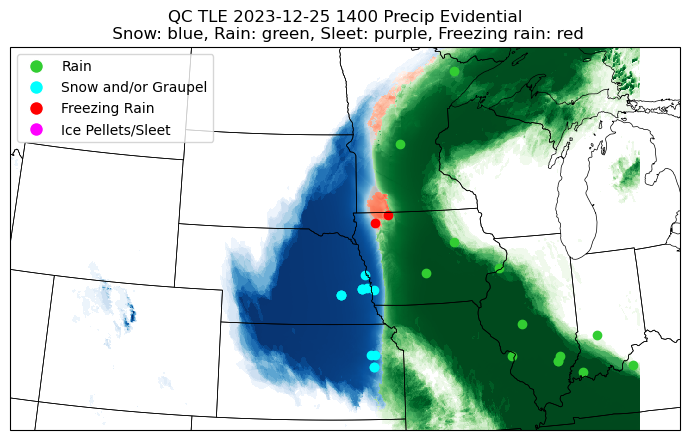

In [15]:
ax = plot_ptype(ds, extent=[-110, -84, 36, 48])
plot_mping(ax, qc_data, colors)
plt.title(f'QC TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')
plt.tight_layout()
plt.savefig("ptype_mping_qc_2023-12-25_1400.png", dpi=300)

Text(0.5, 1.0, 'TLE 2023-12-25 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

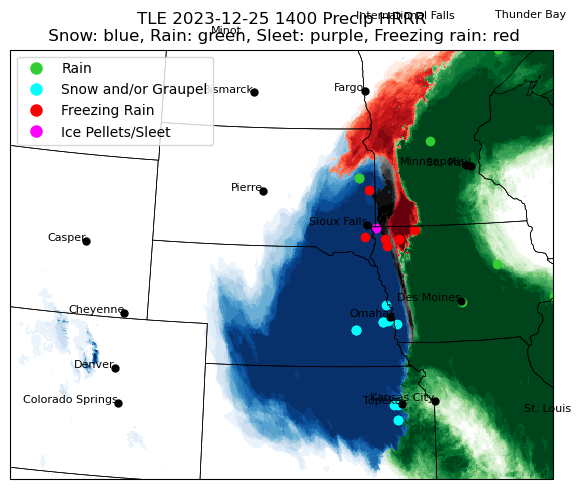

In [92]:
ax = plot_hrrr_ptype(ds)
plot_mping(ax, json_data['results'], colors)
plt.title(f'TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

Text(0.5, 1.0, 'TLE 2023-12-25 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

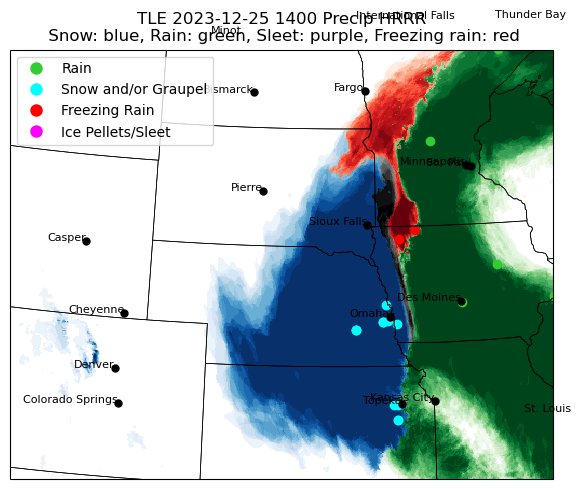

In [93]:
ax = plot_hrrr_ptype(ds)
plot_mping(ax, qc_data, colors)
plt.title(f'TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

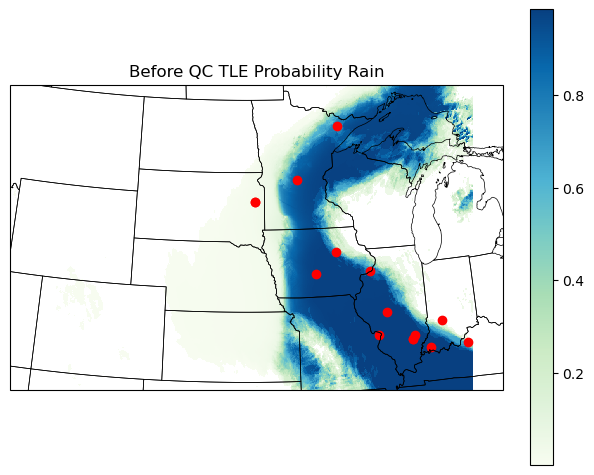

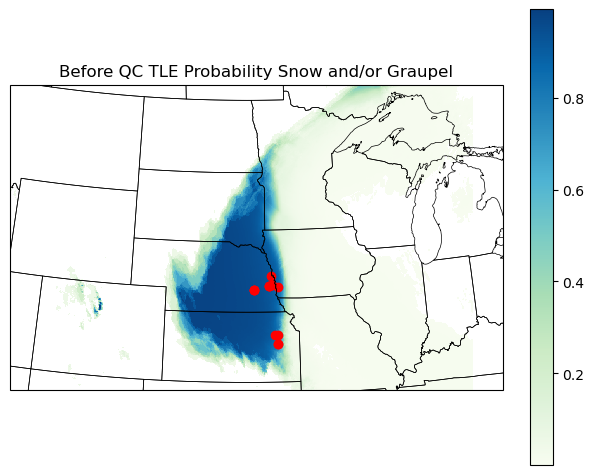

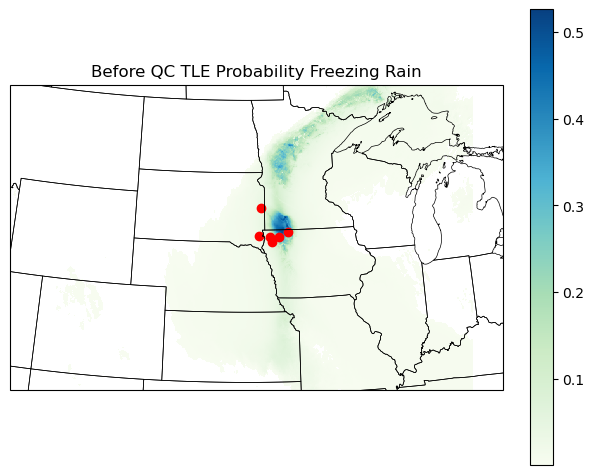

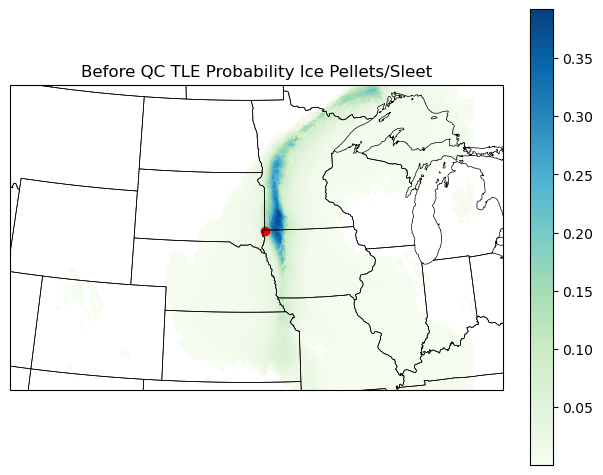

In [94]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-110, -84, 36, 49], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'Before QC TLE Probability {longn_ptype}')

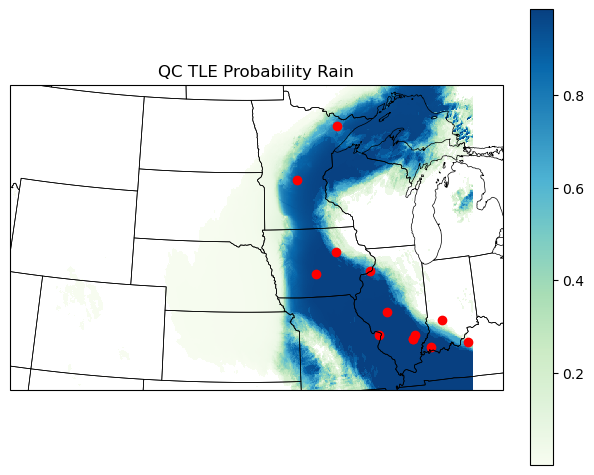

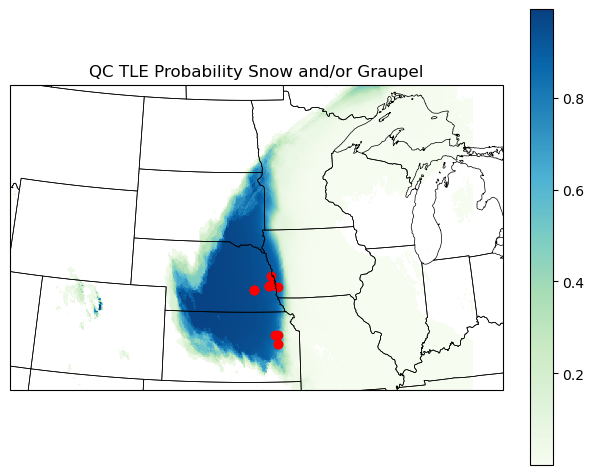

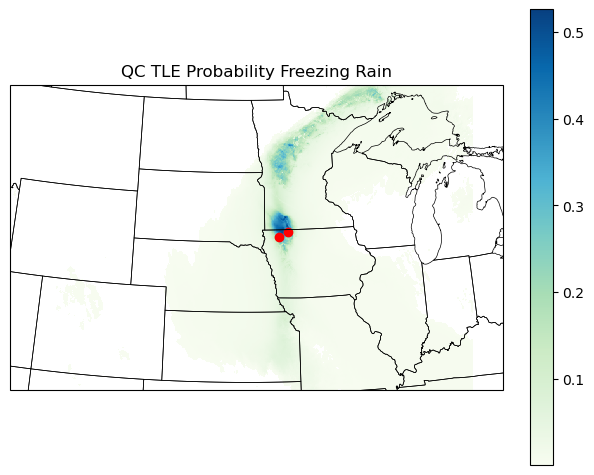

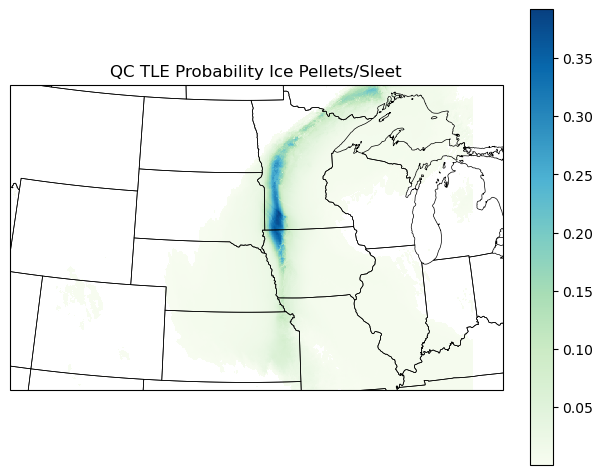

In [95]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-110, -84, 36, 49], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in qc_data:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'QC TLE Probability {longn_ptype}')

(487, 732)
Coordinate 263.551536087346, 43.45984056820308 is closest to grid point (lon, lat) = (263.56719970703125, 43.450531005859375) at row 251, col 403
[0.091417104]


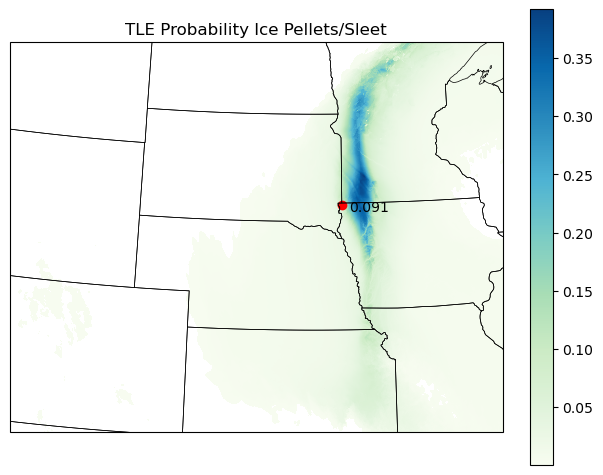

In [97]:
plot_prob_coords(tree, json_data['results'], 'icep', 'Ice Pellets/Sleet')

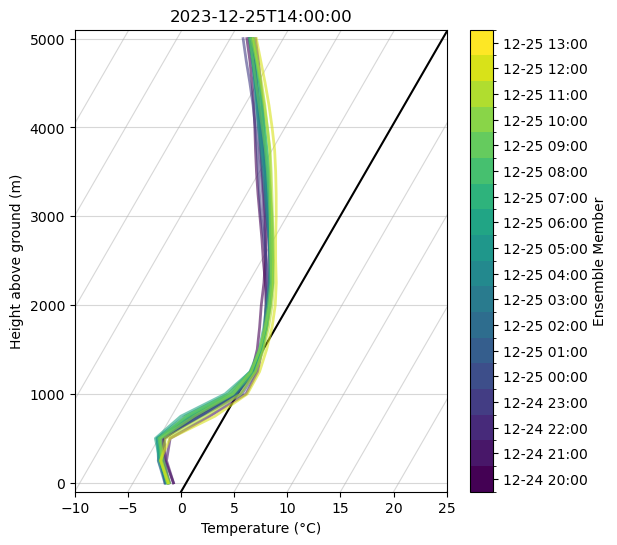

In [98]:
# plot temp sounding at the 0.378 prob.
temp_sounding(ds, (251, 403), 18)

Looking at the hour ahead

In [78]:
json_data = get_json(reqheaders, '2023-12-25 13:00:00', '2023-12-25 13:59:59')

Request Successful


In [79]:
qc_data = qc_mping(ds, json_data)

0:00:29.706477


Text(0.5, 1.0, 'TLE 2023-12-25 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

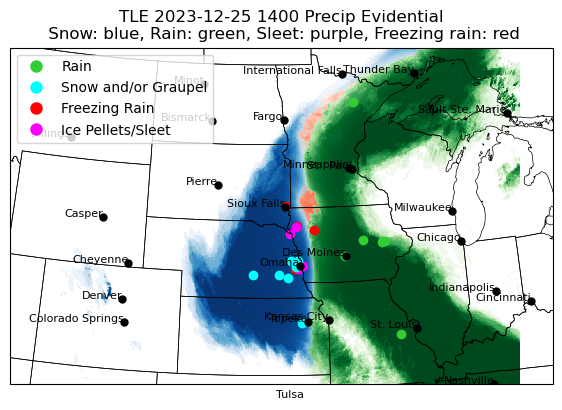

In [83]:
ax = plot_ptype(ds, extent=[-110, -84, 36, 49])
plot_mping(ax, json_data['results'], colors, extent=[-110, -84, 36, 49])
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

Text(0.5, 1.0, 'TLE 2023-12-25 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

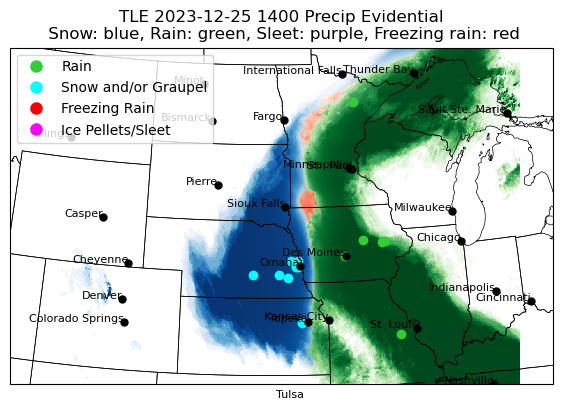

In [85]:
ax = plot_ptype(ds, extent=[-110, -84, 36, 49])
plot_mping(ax, qc_data, colors, extent=[-110, -84, 36, 49])
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

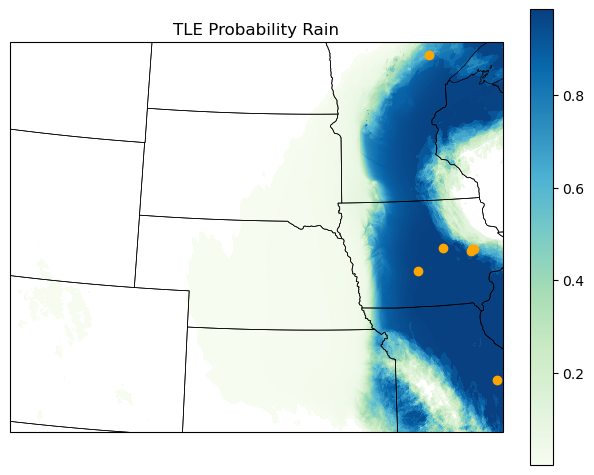

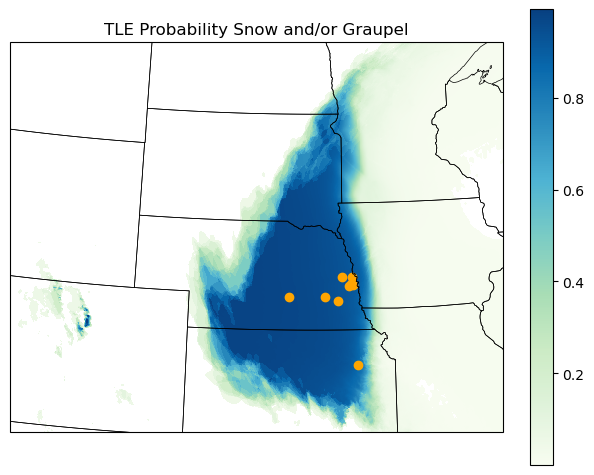

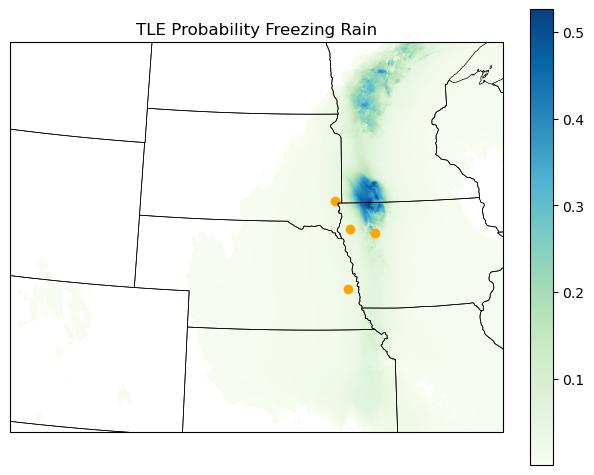

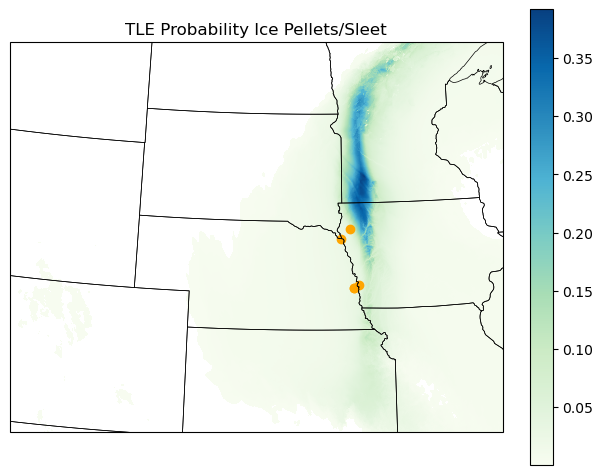

In [44]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

(439, 528)


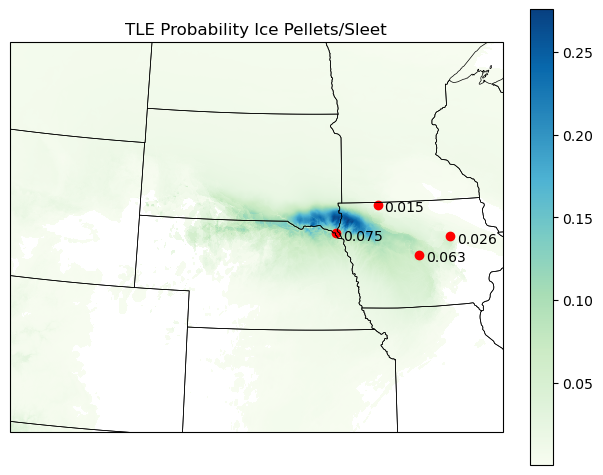

In [46]:
plot_prob_coords("icep", "Ice Pellets/Sleet")

(439, 528)


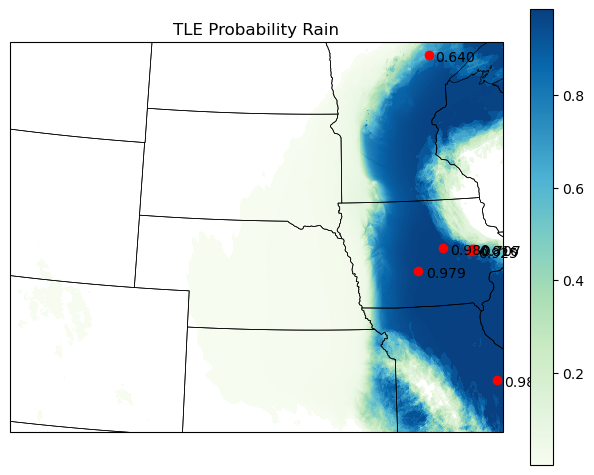

In [46]:
plot_prob_coords("rain", "Rain")

(439, 528)


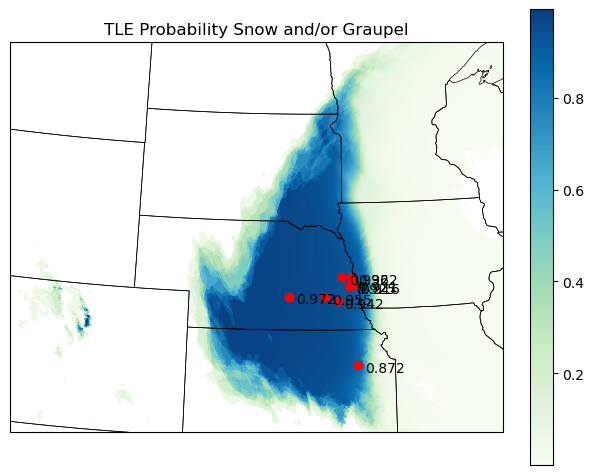

In [48]:
plot_prob_coords("snow", "Snow and/or Graupel")

(439, 528)


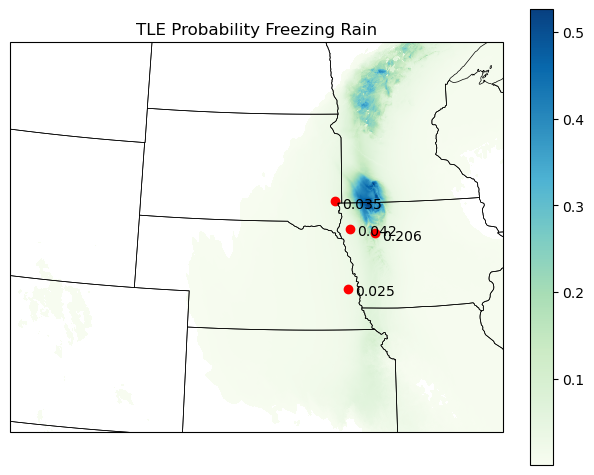

In [47]:
plot_prob_coords("frzr", "Freezing Rain")

## Case Study 3: 

Let's compare mping data to categorization for an entire precip event: 3-24-2024 to 3-26-2024. It's not exactly a perfect comparison since the precipitation features change over time, but hopefully we can get a general idea.

In [38]:
json_data = get_json(reqheaders, '2024-03-24 00:00:00', '2024-03-26 23:59:59')

Request Successful


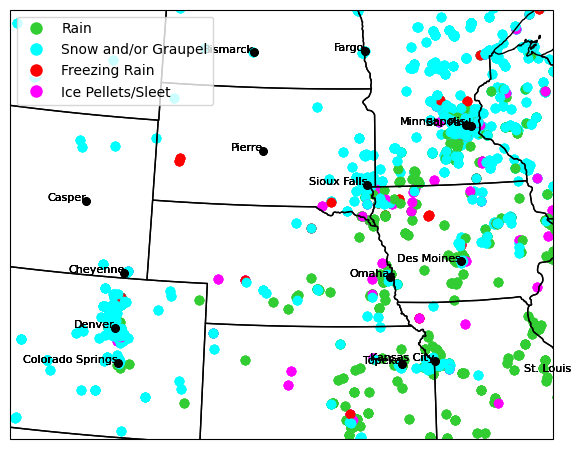

In [39]:
projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
extent = [-108, -91, 37, 47.5]    
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)

for i, js in enumerate(json_data):
    plot_mping(ax, json_data, colors)

Plotting evidential points will require more logic